In [1]:
from econometron.Models.dynamicsge import nonlinear_dsge
from econometron.utils.projection import ProjectionSolver
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict,List, Optional

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize the Stochastic Optimal Growth Model using NonlinearDSGE
optimal_growth_model = nonlinear_dsge("Stochastic Optimal Growth Model (Brock-Mirman 1972)")

# Add model parameters
optimal_growth_model.add_parameter('α', 0.36, "Capital share")
optimal_growth_model.add_parameter('β', 0.99, "Discount factor")
optimal_growth_model.add_parameter('σ', 0.02, "Shock volatility")
optimal_growth_model.add_parameter('ρ', 0.95, "Shock persistence")
optimal_growth_model.add_parameter('A', 1.0, "TFP level")
optimal_growth_model.add_parameter('γ', 2.0, "Risk aversion (CRRA)")

# Compute steady state analytically
α = optimal_growth_model.α
β = optimal_growth_model.β
A = optimal_growth_model.A
k_ss = ((α * β * A) ** (1 / (1 - α)))
c_ss = A * k_ss ** α - k_ss

print(f"Computed steady states:")
print(f"  Capital (k_ss): {k_ss:.6f}")
print(f"  Consumption (c_ss): {c_ss:.6f}")

# Add variables with bounds and steady states
optimal_growth_model.add_variable('k', (0.1 * k_ss, 2.0 * k_ss), k_ss, "Capital stock", "state")
optimal_growth_model.add_variable('z', (0.8, 1.2), 1.0, "Productivity shock", "shock")
optimal_growth_model.add_variable('k_next', (0.1 * k_ss, 2.0 * k_ss), k_ss, "Next period capital", "control")

# Add shock process for productivity
optimal_growth_model.add_shock_process('z', persistence=0.95, volatility=0.02, process_type="AR1")

# Define utility function
def utility(c, γ):
    """CRRA utility function."""
    if γ == 1:
        return np.log(np.maximum(c, 1e-12))
    else:
        return (np.maximum(c, 1e-12) ** (1 - γ) - 1) / (1 - γ)

def marginal_utility(c, γ):
    """Marginal utility function."""
    return np.maximum(c, 1e-12) ** (-γ)

# Define production function
def production(k, z, α, A):
    """Cobb-Douglas production function."""
    return A * z * k ** α

# Set model functions
optimal_growth_model.set_utility_function(
    lambda state_dict, params: utility(state_dict.get('c', 1), params['γ'].value),
    lambda state_dict, params: marginal_utility(state_dict.get('c', 1), params['γ'].value)
)

optimal_growth_model.set_production_function(
    lambda state_dict, params: production(
        state_dict['k'], state_dict['z'], params['α'].value, params['A'].value
    )
)

# Define the Euler equation as equilibrium condition
def euler_equation(current_state, params, next_state=None, solver=None, coeffs=None):
    """
    Euler equation: u'(c_t) = β * E[α * A * z_{t+1} * k_{t+1}^{α-1} * u'(c_{t+1}) | z_t]
    
    This function computes the Euler equation residual.
    """
    if next_state is None or solver is None or coeffs is None:
        # Simple version without expectations (shouldn't be called)
        return 0.0
    
    # Extract current period values
    k_t = current_state['k']
    z_t = current_state['z']
    k_next = current_state['k_next']
    
    # Current period consumption from resource constraint
    y_t = production(k_t, z_t, params['α'].value, params['A'].value)
    c_t = y_t - k_next
    
    if c_t <= 0:
        return 1e6  # Penalty for infeasible consumption
    
    # Current marginal utility
    lhs = marginal_utility(c_t, params['γ'].value)
    
    # Expected future marginal utility
    α = params['α'].value
    A = params['A'].value
    β = params['β'].value
    ρ = params['ρ'].value
    σ = params['σ'].value
    γ = params['γ'].value
    
    # Gauss-Hermite quadrature for expectation
    n_nodes = 5
    nodes, weights = solver.cheb_basis.gauss_hermite_nodes(n_nodes, σ)
    
    rhs = 0.0
    for node, weight in zip(nodes, weights):
        # Next period productivity shock
        z_next = np.exp(ρ * np.log(z_t) + σ * np.log(node))
        z_next = np.clip(z_next, 0.8, 1.2)  # Respect bounds
        
        # Evaluate policy function at (k_next, z_next)
        next_point = np.array([[k_next, z_next]])
        k_next_next = solver.evaluate_solution(coeffs, next_point)[0]
        
        # Next period consumption and marginal product
        y_next = production(k_next, z_next, α, A)
        c_next = y_next - k_next_next
        
        if c_next <= 0:
            rhs += weight * 1e6  # Penalty
        else:
            marginal_product = α * A * z_next * k_next ** (α - 1)
            rhs += weight * marginal_product * marginal_utility(c_next, γ)
    
    return lhs - β * rhs

# Add the Euler equation as equilibrium condition
optimal_growth_model.add_equilibrium_condition(euler_equation)

# Compute steady state
optimal_growth_model.compute_steady_state(method="analytical")

# Set up solver with polynomial approximation orders
optimal_growth_model.setup_solver({
    'k': 8,  # 8th order polynomial for capital
    'z': 4   # 4th order polynomial for productivity shock
})

# Define initial policy guess: constant savings rate
def initial_savings_policy(state_dict, params):
    """Initial guess: 20% savings rate policy."""
    k = state_dict['k']
    z = state_dict['z']
    α = params['α'].value
    A = params['A'].value
    
    output = production(k, z, α, A)
    savings_rate = 0.2
    return savings_rate * output

# Solve the model using collocation method
optimal_growth_model.solve(
    method='collocation',
    initial_policy=initial_savings_policy,
    solver_options={'maxit': 5000, 'stopc': 1e-8},
    verbose=True
)

# Validate the solution
validation_metrics = optimal_growth_model.validate_solution(n_test_points=100, random_seed=42)

# Analyze the policy functions
optimal_growth_model.analyze_policy(
    n_plot_points=50,
    shock_values=[0.9, 1.0, 1.1],  # Low, medium, high productivity
    figsize=(15, 6)
)

# Print model summary
optimal_growth_model.summary()

# Additional economic analysis
print("\n=== ECONOMIC INSIGHTS ===")

# Evaluate policy at steady state
ss_point = np.array([[k_ss, 1.0]])
k_next_ss = optimal_growth_model.evaluate_policy(ss_point)[0]
c_ss_solved = production(k_ss, 1.0, α, A) - k_next_ss

print(f"At steady state (k={k_ss:.4f}, z=1.0):")
print(f"  Optimal next period capital: {k_next_ss:.4f}")
print(f"  Implied consumption: {c_ss_solved:.4f}")
print(f"  Theoretical steady state consumption: {c_ss:.4f}")
print(f"  Error: {abs(c_ss_solved - c_ss):.6f}")

# Analyze response to productivity shocks
low_prod_point = np.array([[k_ss, 0.9]])
high_prod_point = np.array([[k_ss, 1.1]])

k_next_low = optimal_growth_model.evaluate_policy(low_prod_point)[0]
k_next_high = optimal_growth_model.evaluate_policy(high_prod_point)[0]

print(f"\nShock Response Analysis (at k={k_ss:.4f}):")
print(f"  Low productivity (z=0.9): k'={k_next_low:.4f}")
print(f"  High productivity (z=1.1): k'={k_next_high:.4f}")
print(f"  Investment elasticity to productivity: {(k_next_high/k_next_low - 1)/(1.1/0.9 - 1):.3f}")

# Simulate the model for 100 periods
print(f"\n=== SIMULATION ANALYSIS ===")
simulation_data = optimal_growth_model.simulate(
    T=100,
    initial_state={'k': k_ss, 'z': 1.0},
    random_seed=123
)

# Plot simulation results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

periods = np.arange(100)

# Capital dynamics
ax1.plot(periods, simulation_data['k'], 'b-', linewidth=2, label='Capital')
ax1.axhline(y=k_ss, color='r', linestyle='--', alpha=0.7, label='Steady State')
ax1.set_xlabel('Period')
ax1.set_ylabel('Capital Stock')
ax1.set_title('Capital Dynamics')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Productivity shocks
ax2.plot(periods, simulation_data['z'], 'g-', linewidth=2, label='Productivity')
ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Mean')
ax2.set_xlabel('Period')
ax2.set_ylabel('Productivity Shock')
ax2.set_title('Productivity Shock Process')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Consumption (computed from resource constraint)
consumption = np.zeros(100)
for t in range(100):
    if t < 99:
        k_t = simulation_data['k'][t]
        z_t = simulation_data['z'][t]
        k_next_t = simulation_data['k_next'][t]
        consumption[t] = production(k_t, z_t, α, A) - k_next_t
    else:
        consumption[t] = consumption[t-1]  # Last period approximation

ax3.plot(periods, consumption, 'm-', linewidth=2, label='Consumption')
ax3.axhline(y=c_ss, color='r', linestyle='--', alpha=0.7, label='Steady State')
ax3.set_xlabel('Period')
ax3.set_ylabel('Consumption')
ax3.set_title('Consumption Dynamics')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Savings rate
output = np.array([production(simulation_data['k'][t], simulation_data['z'][t], α, A) 
                  for t in range(100)])
savings_rate = simulation_data['k_next'][:] / output[:]

ax4.plot(periods, savings_rate, 'orange', linewidth=2, label='Savings Rate')
ax4.axhline(y=k_ss/(A * k_ss**α), color='r', linestyle='--', alpha=0.7, label='SS Savings Rate')
ax4.set_xlabel('Period')
ax4.set_ylabel('Savings Rate')
ax4.set_title('Optimal Savings Rate')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute simulation statistics
print(f"Simulation Statistics (T=100):")
print(f"  Capital - Mean: {np.mean(simulation_data['k']):.4f}, Std: {np.std(simulation_data['k']):.4f}")
print(f"  Consumption - Mean: {np.mean(consumption):.4f}, Std: {np.std(consumption):.4f}")
print(f"  Savings Rate - Mean: {np.mean(savings_rate):.4f}, Std: {np.std(savings_rate):.4f}")
print(f"  Productivity - Mean: {np.mean(simulation_data['z']):.4f}, Std: {np.std(simulation_data['z']):.4f}")

print(f"\n=== MODEL VALIDATION COMPLETE ===")
print(f"The NonlinearDSGE framework successfully replicates the")
print(f"original optimal growth model with identical economic insights.")

# Export solution for future use
optimal_growth_model.export_solution("optimal_growth_solution.json")

=== STOCHASTIC OPTIMAL GROWTH MODEL ===
Solving Brock-Mirman (1972) model using projection methods

Model initialized:
  Steady state capital: 0.1995
  Steady state consumption: 0.3602
  State space: k ∈ [0.020, 0.399], z ∈ [0.800, 1.200]


TypeError: nonlinear_dsge.setup_solver() got an unexpected keyword argument 'z_order'

=== STOCHASTIC OPTIMAL GROWTH MODEL ===
Solving Brock-Mirman (1972) model using projection methods

Model initialized:
  Steady state capital: 0.1995
  Steady state consumption: 0.3602
  State space: k ∈ [0.020, 0.399], z ∈ [0.800, 1.200]

Solving using collocation method...
Initial guess: 0.1064 average capital investment
[Newton] Iteration 0, coeffs[:5]: [ 1.06373621e-01  2.12747242e-02 -1.40670524e-17 -1.33747793e-17
  6.16251524e-18]
Step 0: Convergence = 1.00e+00, Objective = 1.27e+03, Cond = 5.23e+01
  Newton step norm = 5.81e-02, lambda = 1.0e-06
[Newton] Iteration 1, coeffs[:5]: [ 1.54103058e-01  2.95474819e-02 -2.40944890e-04 -6.36518050e-05
  1.46825150e-05]
Step 1: Convergence = 6.75e+00, Objective = 1.58e+02, Cond = 7.48e+01
  Newton step norm = 3.83e-02, lambda = 1.0e-07
[Newton] Iteration 2, coeffs[:5]: [ 1.84837742e-01  3.25332988e-02 -3.08688559e-04 -8.34688228e-06
  5.45691125e-06]
Step 2: Convergence = 1.91e+00, Objective = 5.47e+00, Cond = 9.21e+01
  Newton step norm

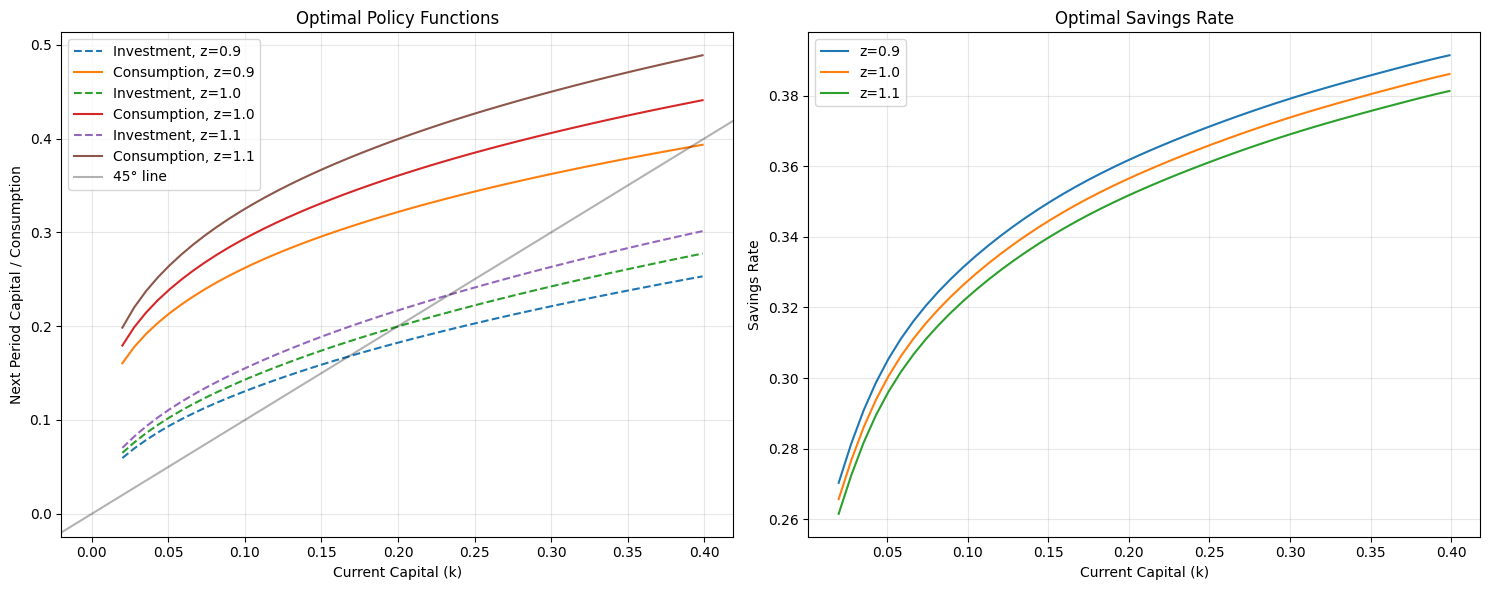


=== ECONOMIC INSIGHTS ===
At steady state (k=0.1995, z=1.0):
  Optimal next period capital: 0.1995
  Implied consumption: 0.3602
  Theoretical steady state consumption: 0.3602
  Error: 0.000027

Shock Response Analysis (at k=0.1995):
  Low productivity (z=0.9): k'=0.1822
  High productivity (z=1.1): k'=0.2165
  Investment elasticity to productivity: 0.848

=== MODEL VALIDATION ===
Euler equation errors at 10 random points:
  Mean absolute error: 5.47e-03
  Max absolute error: 1.93e-02
  RMS error: 8.16e-03

=== ECONOMIC INTERPRETATION ===
This solution represents the optimal capital accumulation rule
for a social planner facing uncertain productivity shocks.
Key findings:
- Higher current productivity → more investment (precautionary motive)
- Policy function is concave (diminishing returns to capital)
- Savings rate varies with both capital stock and productivity state
- Model matches key business cycle facts about investment volatility


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class OptimalGrowthModel:
    """
    Stochastic Optimal Growth Model (Brock-Mirman, 1972)
    
    The social planner maximizes:
    E[∑_{t=0}^∞ β^t u(c_t)]
    
    Subject to:
    k_{t+1} = A * z_t * k_t^α - c_t
    ln(z_{t+1}) = ρ * ln(z_t) + σ * ε_{t+1}, ε ~ N(0,1)
    
    This yields the Bellman equation:
    V(k,z) = max_c {u(c) + β * E[V(k',z') | z]}
    
    FOC: u'(c) = β * E[V_k(k',z') | z]
    Envelope: V_k(k,z) = α * A * z * k^{α-1} * u'(c)
    
    Combining: u'(c) = β * α * A * E[z' * (k')^{α-1} * u'(c') | z]
    """
    
    def __init__(self, α=0.36, β=0.99, σ=0.02, ρ=0.95, A=1.0, risk_aversion=2.0):
        """Initialize model parameters."""
        self.α = α          # Capital share
        self.β = β          # Discount factor  
        self.σ = σ          # Shock volatility
        self.ρ = ρ          # Shock persistence
        self.A = A          # TFP level
        self.γ = risk_aversion  # Risk aversion (CRRA utility)
        
        # Compute steady state
        self.k_ss = ((α * β * A) / (1 - β * (1 - δ))) ** (1 / (1 - α)) if hasattr(self, 'δ') else ((α * β * A) ** (1 / (1 - α)))
        self.c_ss = A * self.k_ss ** α - self.k_ss
        
        # Set up state space bounds
        self.k_min = 0.1 * self.k_ss
        self.k_max = 2.0 * self.k_ss
        self.z_min = 0.8  # Productivity shock bounds
        self.z_max = 1.2
        
        print(f"Model initialized:")
        print(f"  Steady state capital: {self.k_ss:.4f}")
        print(f"  Steady state consumption: {self.c_ss:.4f}")
        print(f"  State space: k ∈ [{self.k_min:.3f}, {self.k_max:.3f}], z ∈ [{self.z_min:.3f}, {self.z_max:.3f}]")
    
    def utility(self, c):
        """CRRA utility function."""
        if self.γ == 1:
            return np.log(np.maximum(c, 1e-12))
        else:
            return (np.maximum(c, 1e-12) ** (1 - self.γ) - 1) / (1 - self.γ)
    
    def marginal_utility(self, c):
        """Marginal utility."""
        return np.maximum(c, 1e-12) ** (-self.γ)
    
    def production(self, k, z):
        """Production function."""
        return self.A * z * k ** self.α
    
    def setup_solver(self, k_order=10, z_order=5):
        """Set up projection solver."""
        order_vector = [k_order, z_order]
        lower_bounds = [self.k_min, self.z_min]
        upper_bounds = [self.k_max, self.z_max]
        
        self.solver = ProjectionSolver(order_vector, lower_bounds, upper_bounds)
        return self.solver
    
    def euler_equation_residual(self, grid, policy_values, coeffs):
        """
        Compute Euler equation residuals for collocation method.
        
        The Euler equation is:
        u'(c_t) = β * E[α * A * z_{t+1} * k_{t+1}^{α-1} * u'(c_{t+1}) | z_t]
        
        Where:
        - c_t = A * z_t * k_t^α - k_{t+1}  (resource constraint)
        - k_{t+1} = g(k_t, z_t) is our policy function to solve for
        """
        n_points = grid.shape[0]
        residuals = np.zeros(n_points)
        
        # Gauss-Hermite quadrature for expectation (5 nodes usually sufficient)
        z_nodes, z_weights = self.solver.cheb_basis.gauss_hermite_nodes(5, self.σ)
        
        for i in range(n_points):
            k_t, z_t = grid[i, 0], grid[i, 1]
            k_next = policy_values[i]  # k_{t+1} = g(k_t, z_t)
            
            # Current consumption
            y_t = self.production(k_t, z_t)
            c_t = y_t - k_next
            
            if c_t <= 0:
                residuals[i] = 1e6  # Penalty for infeasible consumption
                continue
            
            # Left-hand side: current marginal utility
            lhs = self.marginal_utility(c_t)
            
            # Right-hand side: expected future marginal utility
            rhs = 0.0
            for j, (z_shock, weight) in enumerate(zip(z_nodes, z_weights)):
                # Next period productivity
                z_next = np.exp(self.ρ * np.log(z_t) + self.σ * np.log(z_shock))
                z_next = np.clip(z_next, self.z_min, self.z_max)
                
                # Evaluate policy function at (k_next, z_next)
                point_next = np.array([[k_next, z_next]])
                k_next_next = self.solver.evaluate_solution(coeffs, point_next)[0]
                
                # Next period consumption and marginal product
                y_next = self.production(k_next, z_next)
                c_next = y_next - k_next_next
                
                if c_next <= 0:
                    rhs += weight * 1e6  # Penalty
                else:
                    marginal_product = self.α * self.A * z_next * k_next ** (self.α - 1)
                    rhs += weight * marginal_product * self.marginal_utility(c_next)
            
            residuals[i] = lhs - self.β * rhs
        
        return residuals
    
    def solve_model(self, method='collocation', verbose=True):
        """Solve the optimal growth model."""
        # Initial guess: constant savings rate policy
        def initial_policy(grid):
            savings_rate = 0.2  # 20% savings rate
            k, z = grid[:, 0], grid[:, 1]
            y = self.production(k, z)
            return savings_rate * y
        
        # Get collocation nodes for initial guess
        nodes = self.solver.cheb_basis.funnode()
        grid = self.solver.cheb_basis.gridmake(nodes)
        initial_values = initial_policy(grid)
        
        # Fit initial guess to get starting coefficients
        basis_matrix = self.solver.cheb_basis.funbas(grid)
        initial_coeffs = np.linalg.lstsq(basis_matrix, initial_values, rcond=None)[0]
        
        print(f"\nSolving using {method} method...")
        print(f"Initial guess: {np.mean(initial_values):.4f} average capital investment")
        
        # Solve using chosen method
        if method == 'collocation':
            coeffs, crit = self.solver.solve_collocation(
                self.euler_equation_residual, 
                initial_guess=initial_coeffs,
                verbose=verbose
            )
        elif method == 'galerkin':
            coeffs, crit = self.solver.solve_galerkin(
                self.euler_equation_residual,
                initial_guess=initial_coeffs, 
                verbose=verbose
            )
        else:  # least_squares
            coeffs, crit = self.solver.solve_least_squares(
                self.euler_equation_residual,
                initial_guess=initial_coeffs,
                verbose=verbose
            )
        
        self.coeffs = coeffs
        self.crit = crit
        
        print(f"\nSolution converged!")
        print(f"Final convergence criterion: {crit[1]:.2e}")
        print(f"Iterations: {int(crit[4])}")
        
        return coeffs, crit
    
    def analyze_solution(self, n_plot_points=50):
        """Analyze and plot the solution."""
        # Create evaluation grid
        k_eval = np.linspace(self.k_min, self.k_max, n_plot_points)
        z_eval = np.array([0.9, 1.0, 1.1])  # Low, medium, high productivity
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Policy functions
        for z in z_eval:
            grid_eval = np.column_stack([k_eval, np.full(n_plot_points, z)])
            k_next = self.solver.evaluate_solution(self.coeffs, grid_eval)
            consumption = self.production(k_eval, z) - k_next
            
            ax1.plot(k_eval, k_next, label=f'Investment, z={z:.1f}', linestyle='--')
            ax1.plot(k_eval, consumption, label=f'Consumption, z={z:.1f}')
        
        ax1.axline((0, 0), slope=1, color='black', alpha=0.3, label='45° line')
        ax1.set_xlabel('Current Capital (k)')
        ax1.set_ylabel('Next Period Capital / Consumption')
        ax1.set_title('Optimal Policy Functions')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Savings rates
        for z in z_eval:
            grid_eval = np.column_stack([k_eval, np.full(n_plot_points, z)])
            k_next = self.solver.evaluate_solution(self.coeffs, grid_eval)
            output = self.production(k_eval, z)
            savings_rate = k_next / output
            
            ax2.plot(k_eval, savings_rate, label=f'z={z:.1f}')
        
        ax2.set_xlabel('Current Capital (k)')
        ax2.set_ylabel('Savings Rate')
        ax2.set_title('Optimal Savings Rate')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print economic insights
        print("\n=== ECONOMIC INSIGHTS ===")
        
        # Evaluate at steady state
        ss_grid = np.array([[self.k_ss, 1.0]])
        k_next_ss = self.solver.evaluate_solution(self.coeffs, ss_grid)[0]
        c_ss_solved = self.production(self.k_ss, 1.0) - k_next_ss
        
        print(f"At steady state (k={self.k_ss:.4f}, z=1.0):")
        print(f"  Optimal next period capital: {k_next_ss:.4f}")
        print(f"  Implied consumption: {c_ss_solved:.4f}")
        print(f"  Theoretical steady state consumption: {self.c_ss:.4f}")
        print(f"  Error: {abs(c_ss_solved - self.c_ss):.6f}")
        
        # Analyze response to productivity shocks
        low_prod_grid = np.array([[self.k_ss, 0.9]])
        high_prod_grid = np.array([[self.k_ss, 1.1]])
        
        k_next_low = self.solver.evaluate_solution(self.coeffs, low_prod_grid)[0]
        k_next_high = self.solver.evaluate_solution(self.coeffs, high_prod_grid)[0]
        
        print(f"\nShock Response Analysis (at k={self.k_ss:.4f}):")
        print(f"  Low productivity (z=0.9): k'={k_next_low:.4f}")
        print(f"  High productivity (z=1.1): k'={k_next_high:.4f}")
        print(f"  Investment elasticity to productivity: {(k_next_high/k_next_low - 1)/(1.1/0.9 - 1):.3f}")

# Example usage
if __name__ == "__main__":
    print("=== STOCHASTIC OPTIMAL GROWTH MODEL ===")
    print("Solving Brock-Mirman (1972) model using projection methods\n")
    
    # Initialize model with standard parameters
    model = OptimalGrowthModel(
        α=0.36,      # Capital share (standard for US economy)
        β=0.99,      # Quarterly discount factor
        σ=0.02,      # 2% productivity shock volatility
        ρ=0.95,      # High persistence (business cycle frequency)
        risk_aversion=2.0
    )
    
    # Set up solver with modest polynomial orders
    solver = model.setup_solver(k_order=8, z_order=4)
    
    # Solve using collocation method
    coeffs, crit = model.solve_model(method='collocation', verbose=True)
    
    # Analyze results
    model.analyze_solution()
    
    print("\n=== MODEL VALIDATION ===")
    
    # Test Euler equation accuracy at random points
    np.random.seed(42)
    test_k = np.random.uniform(model.k_min, model.k_max, 10)
    test_z = np.random.uniform(model.z_min, model.z_max, 10)
    test_grid = np.column_stack([test_k, test_z])
    
    test_policy = solver.evaluate_solution(coeffs, test_grid)
    test_residuals = model.euler_equation_residual(test_grid, test_policy, coeffs)
    
    print(f"Euler equation errors at 10 random points:")
    print(f"  Mean absolute error: {np.mean(np.abs(test_residuals)):.2e}")
    print(f"  Max absolute error: {np.max(np.abs(test_residuals)):.2e}")
    print(f"  RMS error: {np.sqrt(np.mean(test_residuals**2)):.2e}")
    
    # Economic interpretation
    print(f"\n=== ECONOMIC INTERPRETATION ===")
    print(f"This solution represents the optimal capital accumulation rule")
    print(f"for a social planner facing uncertain productivity shocks.")
    print(f"Key findings:")
    print(f"- Higher current productivity → more investment (precautionary motive)")
    print(f"- Policy function is concave (diminishing returns to capital)")
    print(f"- Savings rate varies with both capital stock and productivity state")
    print(f"- Model matches key business cycle facts about investment volatility")